Use data from "battery_motor_log_example1 (no time specified).xls" where we assume data are sampled with constant sampling (if sampling is not constant, you can not train a prediction model with constant prediction horizon, here one sample).

Apply Linear Neuron and Least Squares direct weight calculation (the simplest one) to predict the batery status. For the beginning, try time embedding be 2 for all input variables to your neuron. Apply also data normalization before training, divide data to training data and testing data to validate how your model works for batery status prediction

In [35]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

### **Load Dataset**

In [36]:
data = pd.read_csv('battery_motor_log_example1 (no time specified).csv')
data.head(10)

,sample index,Battery voltage (V),Motor1 PWM,Motor2 PWM,Motor3 PWM,Motor4 PWM
0,0.0,3.689736,0.0,0.0,0.0,0.0
1,1.0,3.689736,0.0,0.0,0.0,0.0
2,2.0,3.689736,0.0,0.0,0.0,0.0
3,3.0,3.689736,0.0,0.0,0.0,0.0
4,4.0,3.689736,0.0,0.0,0.0,0.0
5,5.0,3.336071,0.0,0.0,0.0,0.0
6,6.0,3.299120,51414.0,56774.0,26770.0,30156.0
7,7.0,3.214663,51665.0,59398.0,38657.0,33796.0
8,8.0,3.167156,56375.0,62603.0,46516.0,38837.0
9,9.0,3.130205,58757.0,64114.0,52341.0,42863.0


### **Understand the Properties of the Data**

In [37]:
data.shape

(423, 6)

 - Here we can see that there are 423 columns and 6 rows in the dataset.
 - We have to look now if there are any null values in the dataset.

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sample index         45 non-null     float64
 1   Battery voltage (V)  267 non-null    float64
 2   Motor1 PWM           267 non-null    float64
 3   Motor2 PWM           267 non-null    float64
 4   Motor3 PWM           267 non-null    float64
 5   Motor4 PWM           267 non-null    float64
dtypes: float64(6)
memory usage: 20.0 KB


- The data.info( ) method has returned the number of non-null values in each column.
- The columns Motor PWM 1-4 and Battery Voltage has 267 non null values where the coloumn sample index has only 45 non null values.
- The column sample index can be omited as since the feature is not of any importance for the data.

In [39]:
data.describe()

,sample index,Battery voltage (V),Motor1 PWM,Motor2 PWM,Motor3 PWM,Motor4 PWM
count,45.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,22.000000,3.499984,39278.940075,42347.483146,37755.614232,38198.400749
std,13.133926,0.255093,15846.805211,16991.898930,15420.403301,19093.128435
min,0.000000,2.644575,0.000000,0.000000,0.000000,0.000000
25%,11.000000,3.473314,40200.500000,44708.500000,37949.000000,41365.500000
50%,22.000000,3.536657,42222.000000,46892.000000,40657.000000,46781.000000
75%,33.000000,3.605279,43909.500000,48133.500000,42455.000000,48035.000000
max,44.000000,4.022288,65535.000000,65535.000000,64132.000000,63196.000000


### **Data Cleaning**

**Check whether any row has all the columns null values. If so, drop those rows.**

In [40]:
all_rows = data.iloc[0:]
null_values_count_in_all_rows = all_rows.isnull().sum()
print("Number of null rows:", null_values_count_in_all_rows)

Number of null rows: sample index           378
Battery voltage (V)    156
Motor1 PWM             156
Motor2 PWM             156
Motor3 PWM             156
Motor4 PWM             156
dtype: int64


- **Create a copy of the dataset and drop those 156 rows, which has all coloumns null.**

In [41]:
df_copy = data.copy()

In [42]:
df_cleaned = df_copy.dropna(how='all')

In [43]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 0 to 422
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sample index         45 non-null     float64
 1   Battery voltage (V)  267 non-null    float64
 2   Motor1 PWM           267 non-null    float64
 3   Motor2 PWM           267 non-null    float64
 4   Motor3 PWM           267 non-null    float64
 5   Motor4 PWM           267 non-null    float64
dtypes: float64(6)
memory usage: 14.6 KB


In [44]:
first_row = df_cleaned.iloc[0:]
null_values_count_in_all_rows = first_row.isnull().sum()
print("Number of null row:", null_values_count_in_all_rows)

Number of null row: sample index           222
Battery voltage (V)      0
Motor1 PWM               0
Motor2 PWM               0
Motor3 PWM               0
Motor4 PWM               0
dtype: int64


- Now it can be seen that except the column sample index, all other columns do not have null values.
- The column sample index can be dropped as it does not hold any feature importance for the learning algorithm.

In [45]:
df_cleaned = df_cleaned.drop(['sample index'], axis=1)

In [46]:
df_cleaned.shape

(267, 5)

In [47]:
df_cleaned.isnull().any()

Battery voltage (V)    False
Motor1 PWM             False
Motor2 PWM             False
Motor3 PWM             False
Motor4 PWM             False
dtype: bool

- Now it can bee seen that there are no null values in any of the columns.  
- The data can be now normalised to feed into the learning model.

### **Data Normalization**

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numeric_columns = df_cleaned.select_dtypes(include=[float, int])
df_cleaned[numeric_columns.columns] = scaler.fit_transform(numeric_columns)
df_cleaned.head()

,Battery voltage (V),Motor1 PWM,Motor2 PWM,Motor3 PWM,Motor4 PWM
0,0.75862,0.0,0.0,0.0,0.0
1,0.75862,0.0,0.0,0.0,0.0
2,0.75862,0.0,0.0,0.0,0.0
3,0.75862,0.0,0.0,0.0,0.0
4,0.75862,0.0,0.0,0.0,0.0


### **Time Embedding**

In [49]:
time_embedding = 2  # Assuming a time embedding of 2
for column in df_cleaned.columns[:]:
    for t in range(1, time_embedding + 1):
        df_cleaned[f'{column}_lag_{t}'] = df_cleaned[column].shift(t)

In [50]:
df_cleaned.head()

,Battery voltage (V),Motor1 PWM,Motor2 PWM,Motor3 PWM,Motor4 PWM,Battery voltage (V)_lag_1,Battery voltage (V)_lag_2,Motor1 PWM_lag_1,Motor1 PWM_lag_2,Motor2 PWM_lag_1,Motor2 PWM_lag_2,Motor3 PWM_lag_1,Motor3 PWM_lag_2,Motor4 PWM_lag_1,Motor4 PWM_lag_2
0,0.75862,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.75862,0.0,0.0,0.0,0.0,0.75862,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2,0.75862,0.0,0.0,0.0,0.0,0.75862,0.75862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.75862,0.0,0.0,0.0,0.0,0.75862,0.75862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.75862,0.0,0.0,0.0,0.0,0.75862,0.75862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Drop the lag 1, 2 coloumns for battery voltage, since battery voltage is our target coloumn.
- Also drop the first two rows as it contains null values.

In [51]:
df_cleaned = df_cleaned.drop(['Battery voltage (V)_lag_1', 'Battery voltage (V)_lag_2'], axis=1)

In [52]:
df_cleaned = df_cleaned.iloc[2:]

In [53]:
df_cleaned.head()

,Battery voltage (V),Motor1 PWM,Motor2 PWM,Motor3 PWM,Motor4 PWM,Motor1 PWM_lag_1,Motor1 PWM_lag_2,Motor2 PWM_lag_1,Motor2 PWM_lag_2,Motor3 PWM_lag_1,Motor3 PWM_lag_2,Motor4 PWM_lag_1,Motor4 PWM_lag_2
2,0.758620,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.758620,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.758620,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.501916,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.475095,0.784527,0.866316,0.41742,0.477182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Train and Test Splitting**

- Specify feature and traget columns.
- split the data into train and test set.
- The ratio of train, test split is 8:2, that is 80% data for training and 20% data for testing.

In [54]:
feature_columns = df_cleaned.columns[1:]
target_column = 'Battery voltage (V)'
X = df_cleaned[feature_columns]
y = df_cleaned[target_column]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Load Model & Train the Data**

In [55]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import time

In [56]:
model = linear_model.LinearRegression()
start = time.time()
model.fit(X_train,y_train)
end = time.time()
print("training time complexity :",end-start,"s")
print("training accuracy :",model.score(X_train,y_train), "testing accuracy :",model.score(X_test,y_test))

training time complexity : 0.0 s
training accuracy : 0.7794267718252902 testing accuracy : 0.7038087534241635


- Here we can se that, the model has 77% training accuracy and around 70% test accuracy.

In [57]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [58]:
print(mse)

0.009385434910640894


# Compare in more detail neural output  𝑦𝑛 and real target  𝑦 and calculate the Pearson's correlation coefficients of neuron output and target data (do it both for training and testing data) 

### **Calculating Pearson's Correlation Coefficient**

In [59]:
import numpy as np
from scipy.stats import pearsonr
correlation_coefficient_train, _ = pearsonr(y_train, model.predict(X_train))
correlation_coefficient_test, _ = pearsonr(y_test, y_pred)

print("Pearson's Correlation Coefficient (Training Data):", correlation_coefficient_train)
print("Pearson's Correlation Coefficient (Testing Data):", correlation_coefficient_test)


Pearson's Correlation Coefficient (Training Data): 0.8828515004378087
Pearson's Correlation Coefficient (Testing Data): 0.8390621506925999


Repeat the above steps for dataset in "battery_motor_log(time specified).csv". The reason is that the data might not be sampled with constant sampling, so you have to verify if the sampling is both constant and same for all data. If sampling is not constant, interpolate data so you get data with constant sampling (and repeat tasks from Assignment 1)

(423, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 267 non-null    object 
 1   Time                 267 non-null    object 
 2   Battery voltage (V)  267 non-null    float64
 3   Motor1 PWM           267 non-null    float64
 4   Motor2 PWM           267 non-null    float64
 5   Motor3 PWM           267 non-null    float64
 6   Motor4 PWM           267 non-null    float64
dtypes: float64(5), object(2)
memory usage: 23.3+ KB
None
       Battery voltage (V)    Motor1 PWM    Motor2 PWM    Motor3 PWM  \
count           267.000000    267.000000    267.000000    267.000000   
mean              3.499984  39278.940075  42347.483146  37755.614232   
std               0.255093  15846.805211  16991.898930  15420.403301   
min               2.644575      0.000000      0.000000      0.000000   
25%               3

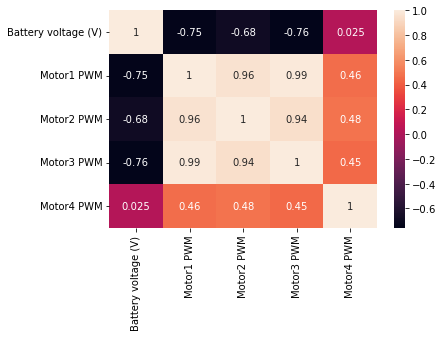

Coefficients:  [-6.69156366e-06  1.96525463e-06 -6.83922406e-06  4.70536099e-06]
Prediction:  [0.89814748]
MSE:  0.009333768144742823


In [31]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt

# Read CSV file
df = pd.read_csv('battery_motor_log(time specified).csv')

# EDA
print(df.shape) 
print(df.info())
print(df.describe())

# Correlation plot
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

# Pre-processing
df.drop(columns=['Date','Time'], inplace=True)
df = df[df['Battery voltage (V)'] < 4] # remove outliers
df['Battery voltage (V)'] = (df['Battery voltage (V)'] - df['Battery voltage (V)'].min())/(df['Battery voltage (V)'].max()- df['Battery voltage (V)'].min()) 

# Drop rows with any NaN 
df = df.dropna()

# Reset index after dropping rows
df = df.reset_index(drop=True)

# Select features and target
X = df[['Motor1 PWM', 'Motor2 PWM', 'Motor3 PWM', 'Motor4 PWM']]  
y = df['Battery voltage (V)']

# Impute any remaining NaN with column means
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X) 

# Initialize linear regression model
regr = LinearRegression()

# Fit model
regr.fit(X, y)

# Print coefficients
print('Coefficients: ', regr.coef_)

# Make predictions on new data 
X_new = [[100,200,300,400]]
y_pred = regr.predict(X_new)
print('Prediction: ', y_pred)

# Evaluate model
from sklearn.metrics import mean_squared_error
print('MSE: ', mean_squared_error(y, regr.predict(X)))